In [4]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO DAS DEPENDÊNCIAS
# ================================================================================
# Executar apenas na primeira vez ou no Colab
%pip install -q catboost tabpfn scikit-learn pandas numpy seaborn xgboost --upgrade
# Para TabPFN 2.5 (necessário aceitar a licença no HuggingFace antes)
%pip install -q "tabpfn>=0.2.0"


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier
import warnings
warnings.filterwarnings('ignore')

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas (conforme documentação UCI)
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cpu'

In [16]:
#%pip install huggingface_hub ipywidgets
from huggingface_hub import notebook_login

notebook_login()


In [2]:
# ================================================================================
# CÉLULA 3: CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS
# ================================================================================
# Carregar dados
df = pd.read_csv(url, names=columns, na_values='?')

# Separar features e target
# O target original é 0 (sem doença) e 1-4 (doença). Vamos binarizar: 0 = sem, 1 = com
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Tratar missing values (ca e thal têm ?)
df['ca'].fillna(df['ca'].median(), inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

# Separar X e y
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset carregado: {X.shape[0]} amostras, {X.shape[1]} features")
print(f"Distribuição da classe: \n{y.value_counts(normalize=True)}")

Dataset carregado: 303 amostras, 13 features
Distribuição da classe: 
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [3]:
# ================================================================================
# CÉLULA 5: FEATURE ENGINEERING
# ================================================================================
# Criar novas features baseadas em conhecimento médico e interações

# Cópia para não modificar o original
X_eng = X.copy()

# 1. Interações cardiovasculares
X_eng['age_thalach'] = X_eng['age'] * X_eng['thalach']           # idade × freq cardíaca máxima
X_eng['age_chol'] = X_eng['age'] * X_eng['chol']                 # idade × colesterol
X_eng['bp_chol'] = X_eng['trestbps'] * X_eng['chol']             # pressão × colesterol
X_eng['thalach_oldpeak'] = X_eng['thalach'] * X_eng['oldpeak']   # freq máx × depressão ST

# 2. Razões (normalizações)
X_eng['chol_per_age'] = X_eng['chol'] / (X_eng['age'] + 1)       # colesterol por idade
X_eng['thalach_per_age'] = X_eng['thalach'] / (X_eng['age'] + 1) # freq máx por idade
X_eng['bp_per_age'] = X_eng['trestbps'] / (X_eng['age'] + 1)     # pressão por idade

# 3. Indicadores de risco combinados
X_eng['cardiac_risk'] = (X_eng['age'] > 50).astype(int) + \
                        (X_eng['chol'] > 240).astype(int) + \
                        (X_eng['trestbps'] > 140).astype(int) + \
                        X_eng['fbs'] + X_eng['exang']

# 4. Substituir X original pelo engenheirado
X = X_eng.copy()

print(f"Features após engenharia: {X.shape[1]} (antes: 13)")
print(f"Novas features: {list(X.columns[13:])}")

Features após engenharia: 21 (antes: 13)
Novas features: ['age_thalach', 'age_chol', 'bp_chol', 'thalach_oldpeak', 'chol_per_age', 'thalach_per_age', 'bp_per_age', 'cardiac_risk']


In [4]:
# ================================================================================
# CÉLULA 6: DIVISÃO TREINO/TESTE (hold-out para avaliação final)
# ================================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (242, 21), Teste: (61, 21)


# Fine Tuning

In [ ]:
# ================================================================================
# CÉLULA EXTRA: OTIMIZAÇÃO BAYESIANA (Optuna)
# ================================================================================
# Instalar optuna se necessário
%pip install -q optuna

import optuna
import json
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

warnings.filterwarnings('ignore')

print("Iniciando Otimização Bayesiana...")

# Definir validação cruzada
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 1. Otimização CatBoost
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False,
        'allow_writing_files': False
    }
    
    model = CatBoostClassifier(**params)
    # Usa X_train e y_train definidos anteriormente
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

study_cat = optuna.create_study(direction='maximize')
print("Otimizando CatBoost...")
study_cat.optimize(objective_catboost, n_trials=30, show_progress_bar=True)
best_cat_params = study_cat.best_params
print(f"Melhores parâmetros CatBoost: {best_cat_params}")

# 2. Otimização Logistic Regression
def objective_lr(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
        
    C = trial.suggest_float('C', 1e-4, 100, log=True)
    
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

study_lr = optuna.create_study(direction='maximize')
print("Otimizando Logistic Regression...")
study_lr.optimize(objective_lr, n_trials=30, show_progress_bar=True)
best_lr_params = study_lr.best_params
print(f"Melhores parâmetros Logistic Regression: {best_lr_params}")

# Salvar resultados
best_results = {
    'catboost': best_cat_params,
    'logistic_regression': best_lr_params,
    'catboost_best_acc': study_cat.best_value,
    'lr_best_acc': study_lr.best_value
}

with open('best_params.json', 'w') as f:
    json.dump(best_results, f, indent=4)

print("\nOtimização concluída! Parâmetros salvos em 'best_params.json'.")

Melhores parâmetros carregados com sucesso.

Iniciando Cross-Validation (10 folds)...
Modelo               | Média Acc  | Std Dev    | Min      | Max     
----------------------------------------------------------------------
CatBoost (Default)   | 0.8218     | 0.0573     | 0.7333   | 0.9032
CatBoost (Tuned)     | 0.8378     | 0.0535     | 0.7667   | 0.9032
LogReg (Default)     | 0.8312     | 0.0611     | 0.7000   | 0.9355
LogReg (Tuned)       | 0.8411     | 0.0594     | 0.7667   | 0.9677


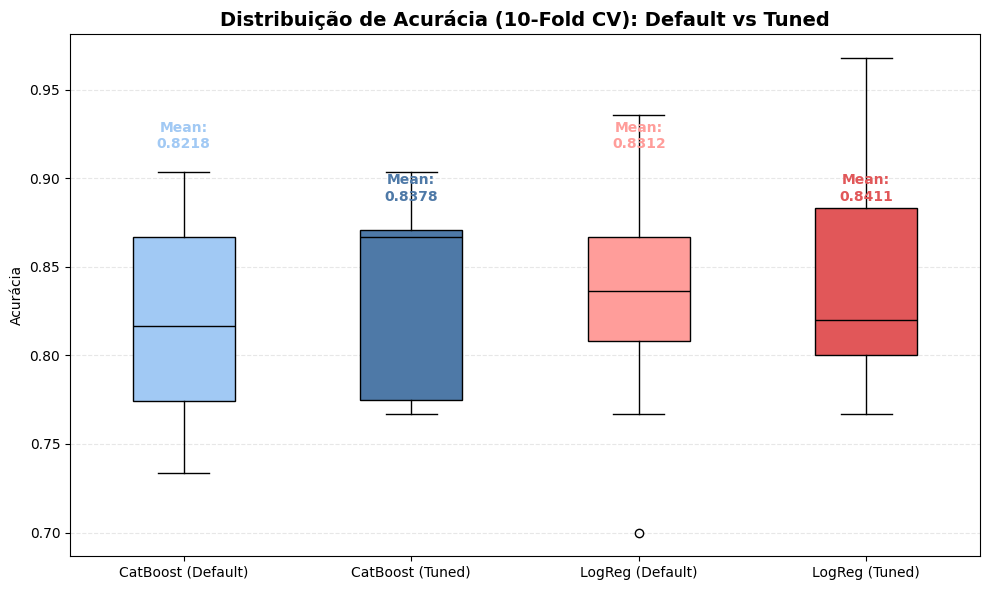

In [41]:
# ================================================================================
# CÉLULA EXTRA: COMPARAÇÃO ROBUSTA (Cross-Validation)
# ================================================================================
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# 1. Carregar Melhores Parâmetros
try:
    with open('best_params.json', 'r') as f:
        best_results = json.load(f)
    best_cat_params = best_results['catboost']
    best_lr_params = best_results['logistic_regression']
    print("Melhores parâmetros carregados com sucesso.")
except FileNotFoundError:
    print("ALERTA: 'best_params.json' não encontrado. Rode a otimização primeiro!")
    best_cat_params = {}
    best_lr_params = {}

# 2. Configurar Modelos (Default vs Tuned)
# CatBoost
cat_default = CatBoostClassifier(verbose=False, random_state=42, allow_writing_files=False)
tuned_cat_args = best_cat_params.copy()
tuned_cat_args.update({'verbose': False, 'random_state': 42, 'allow_writing_files': False})
cat_tuned = CatBoostClassifier(**tuned_cat_args)

# Logistic Regression
lr_default = LogisticRegression(max_iter=1000, random_state=42)
lr_tuned = LogisticRegression(**best_lr_params, max_iter=1000, random_state=42)

# 3. Executar Cross-Validation (10-fold)
# Usamos X e y completos para maior robustez estatística
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models_dict = {
    "CatBoost (Default)": cat_default,
    "CatBoost (Tuned)": cat_tuned,
    "LogReg (Default)": lr_default,
    "LogReg (Tuned)": lr_tuned
}

results = {}
print("\nIniciando Cross-Validation (10 folds)...")
print(f"{'Modelo':<20} | {'Média Acc':<10} | {'Std Dev':<10} | {'Min':<8} | {'Max':<8}")
print("-" * 70)

for name, model in models_dict.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"{name:<20} | {scores.mean():.4f}     | {scores.std():.4f}     | {scores.min():.4f}   | {scores.max():.4f}")

# 4. Visualização (Boxplot)
plt.figure(figsize=(10, 6))
data_to_plot = [results[n] for n in models_dict.keys()]
names = list(models_dict.keys())

# Cores: Azuis para CatBoost, Vermelhos para LR
colors = ['#a1c9f4', '#4e79a7', '#ff9d9a', '#e15759']

bplot = plt.boxplot(data_to_plot, patch_artist=True, labels=names, medianprops=dict(color="black"))

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribuição de Acurácia (10-Fold CV): Default vs Tuned', fontsize=14, fontweight='bold')
plt.ylabel('Acurácia')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar média textual acima de cada box
for i, name in enumerate(names):
    mean_val = results[name].mean()
    plt.text(i+1, plt.ylim()[1]*0.95 if i%2==0 else plt.ylim()[1]*0.92, 
             f'Mean:\n{mean_val:.4f}', 
             ha='center', va='top', fontweight='bold', color=colors[i], fontsize=10)

plt.tight_layout()
plt.show()

# Ensemble Stacking

In [ ]:
# ================================================================================
# CÉLULA: STACKING APRIMORADO (+ Base Learners + Passthrough)
# ================================================================================
import os
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Carregar parâmetros otimizados
try:
    with open('best_params.json', 'r') as f:
        best_results = json.load(f)
    best_cat_params = best_results['catboost']
    best_lr_params = best_results['logistic_regression']
    
    # Garantir parâmetros extras necessários para o CatBoost
    best_cat_params['verbose'] = False
    best_cat_params['allow_writing_files'] = False
    best_cat_params['random_seed'] = RANDOM_STATE
    
    # Garantir random_state para LR
    best_lr_params['random_state'] = RANDOM_STATE
    if 'max_iter' not in best_lr_params:
        best_lr_params['max_iter'] = 1000
        
    print("Usando parâmetros OTIMIZADOS para o Stacking.")
except FileNotFoundError:
    print("AVISO: 'best_params.json' não encontrado. Usando parâmetros padrão.")
    best_cat_params = {
        'iterations': 1000, 'learning_rate': 0.05, 'depth': 6,
        'verbose': False, 'random_seed': RANDOM_STATE
    }
    best_lr_params = {'random_state': RANDOM_STATE}

# Base learners diversificados
estimators = [
    # Gradient Boosting (tuned)
    ('catboost', CatBoostClassifier(**best_cat_params)),
    
    # TabPFN (foundation model)
    ('tabpfn', TabPFNClassifier(device=DEVICE, n_estimators=8)),
    
    # XGBoost (diversidade)
    ('xgboost', XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        random_state=RANDOM_STATE, verbosity=0, use_label_encoder=False
    )),
    
    # Random Forest (bagging - diferente de boosting)
    ('rf', RandomForestClassifier(
        n_estimators=200, max_depth=6, min_samples_leaf=3,
        random_state=RANDOM_STATE, n_jobs=-1
    )),
    
    # SVM (kernel-based - muito diferente dos outros)
    ('svm', SVC(
        kernel='rbf', C=1.0, probability=True,
        random_state=RANDOM_STATE
    ))
]

# Meta-learner = Logistic Regression (tuned)
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(**best_lr_params),
    cv=N_SPLITS,
    stack_method='predict_proba',
    passthrough=True,  # IMPORTANTE: passa features originais para o meta-learner
    n_jobs=-1
)

print(f"Ensemble com {len(estimators)} base learners + passthrough=True")
print("Treinando o Stacking Aprimorado...")
stacking_model.fit(X_train, y_train)
print("Treinamento concluído!")

ModuleNotFoundError: No module named 'tabpfn_extensions'

# Evaluation

In [ ]:
# ================================================================================ 
# AVALIAÇÃO DO MODELO (train_test_split)
# ================================================================================

y_proba = stacking_model.predict_proba(X_test)[:, 1]
y_pred  = stacking_model.predict(X_test)
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
print(f"\n=== RESULTADOS FINAIS (Stacking scikit-learn) ===")
print(f"ROC AUC : {auc:.4f}")
print(f"Accuracy: {acc:.4f}")


# === RESULTADOS FINAIS (Stacking scikit-learn) ===
# ROC AUC : 0.9589
# Accuracy: 0.8689


=== RESULTADOS FINAIS (Stacking scikit-learn) ===
ROC AUC : 0.9556
Accuracy: 0.8852


Executando 10-Fold CV no Stacking Ensemble Otimizado...
Isso pode levar alguns minutos devido ao TabPFN e CatBoost...
Fold 01/10 | Acc: 0.9032 | AUC: 0.9244


[W1202 02:58:10.426102388 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 02:58:42.619461782 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 02/10 | Acc: 0.9032 | AUC: 0.9916
Fold 03/10 | Acc: 0.8387 | AUC: 0.8992
Fold 04/10 | Acc: 0.8000 | AUC: 0.9005
Fold 05/10 | Acc: 0.8333 | AUC: 0.9241


[W1202 03:04:15.473684818 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:04:26.166014295 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:04:35.075345158 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:04:41.685303521 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 06/10 | Acc: 0.8000 | AUC: 0.8348


[W1202 03:04:50.615301428 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:05:00.274331406 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:05:08.262897879 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 03:06:09.623536691 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 07/10 | Acc: 0.8667 | AUC: 0.9643
Fold 08/10 | Acc: 0.7667 | AUC: 0.8705
Fold 09/10 | Acc: 0.9000 | AUC: 0.9464


[W1202 03:09:33.223169865 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


Fold 10/10 | Acc: 0.8000 | AUC: 0.8482

RESULTADO FINAL (10-Fold CV)
Acurácia Média: 0.8412 ± 0.0475
AUC Média:      0.9104 ± 0.0475
Min/Max Acc:    0.7667 / 0.9032


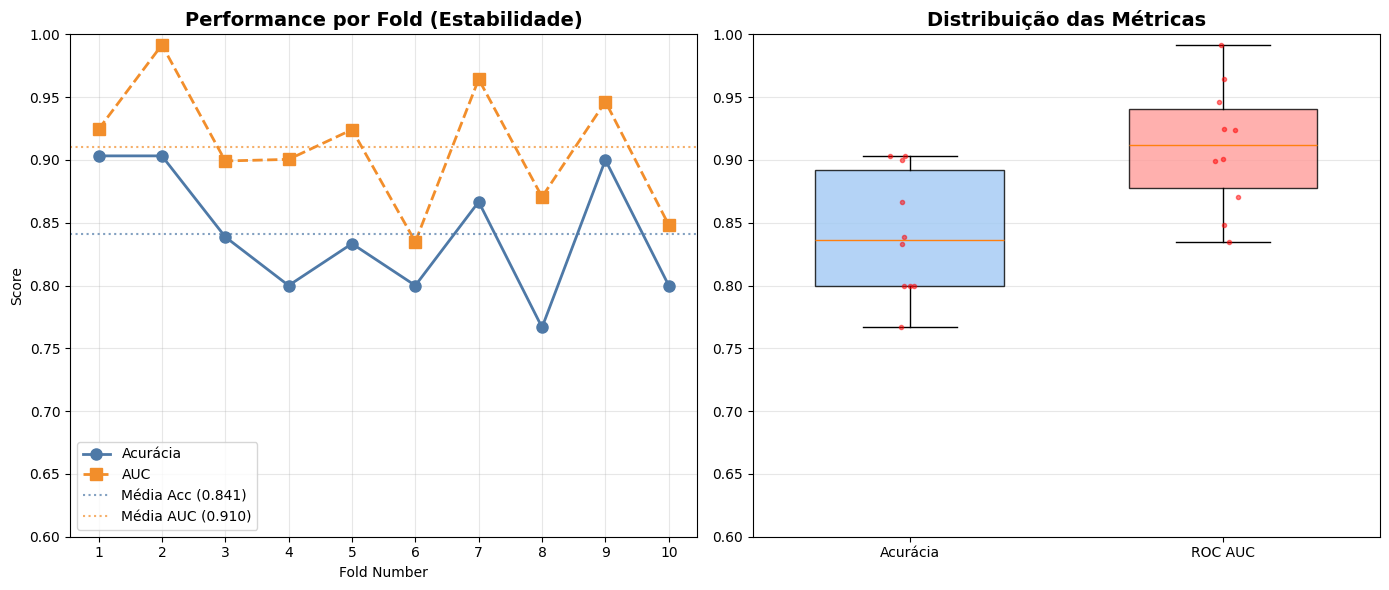

In [ ]:
# ================================================================================
# CÉLULA: 10-FOLD CROSS-VALIDATION DO ENSEMBLE APRIMORADO
# ================================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Configurar CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

print("Executando 10-Fold CV no Stacking Ensemble Aprimorado...")
print("(CatBoost + TabPFN + XGBoost + RF + SVM + Feature Engineering + Passthrough)")
print("Isso pode levar alguns minutos...\n")

acc_scores = []
auc_scores = []
fold_indices = []

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    stacking_model.fit(X_tr, y_tr)
    
    y_pred = stacking_model.predict(X_val)
    y_proba = stacking_model.predict_proba(X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    
    acc_scores.append(acc)
    auc_scores.append(auc)
    fold_indices.append(i + 1)
    
    print(f"Fold {i+1:02d}/10 | Acc: {acc:.4f} | AUC: {auc:.4f}")

# Estatísticas Finais
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("\n" + "="*60)
print(f"RESULTADO FINAL (10-Fold CV) - ENSEMBLE APRIMORADO")
print("="*60)
print(f"Acurácia Média: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"AUC Média:      {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Min/Max Acc:    {min(acc_scores):.4f} / {max(acc_scores):.4f}")

# --- PLOTS ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Performance por Fold
ax1 = axes[0]
ax1.plot(fold_indices, acc_scores, marker='o', linestyle='-', linewidth=2, markersize=8, label='Acurácia', color='#4e79a7')
ax1.plot(fold_indices, auc_scores, marker='s', linestyle='--', linewidth=2, markersize=8, label='AUC', color='#f28e2b')
ax1.axhline(y=mean_acc, color='#4e79a7', linestyle=':', alpha=0.7, label=f'Média Acc ({mean_acc:.3f})')
ax1.axhline(y=mean_auc, color='#f28e2b', linestyle=':', alpha=0.7, label=f'Média AUC ({mean_auc:.3f})')
ax1.set_title('Performance por Fold', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.set_xticks(fold_indices)
ax1.set_ylim(0.65, 1.0)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

# Plot 2: Boxplot
ax2 = axes[1]
data = [acc_scores, auc_scores]
labels = ['Acurácia', 'ROC AUC']
colors = ['#a1c9f4', '#ff9d9a']
bplot = ax2.boxplot(data, patch_artist=True, labels=labels, widths=0.5)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
for i, score_list in enumerate(data):
    y_jitter = np.random.normal(i + 1, 0.04, size=len(score_list))
    ax2.scatter(y_jitter, score_list, alpha=0.6, color='darkblue', s=30)
ax2.set_title('Distribuição das Métricas', fontsize=12, fontweight='bold')
ax2.set_ylim(0.65, 1.0)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Comparação com baseline anterior
ax3 = axes[2]
baseline_acc = 0.8412  # resultado anterior
baseline_auc = 0.9104
models = ['Baseline\n(Cat+Tab)', 'Aprimorado\n(5 modelos)']
acc_comparison = [baseline_acc, mean_acc]
auc_comparison = [baseline_auc, mean_auc]

x = np.arange(len(models))
width = 0.35
bars1 = ax3.bar(x - width/2, acc_comparison, width, label='Acurácia', color='#4e79a7')
bars2 = ax3.bar(x + width/2, auc_comparison, width, label='AUC', color='#f28e2b')

ax3.set_ylabel('Score')
ax3.set_title('Comparação: Antes vs Depois', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.set_ylim(0.75, 1.0)
ax3.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Ganho
print(f"\n→ Ganho em Acurácia: {mean_acc - baseline_acc:+.4f}")
print(f"→ Ganho em AUC:      {mean_auc - baseline_auc:+.4f}")

Avaliação 10-fold CV focada em Acurácia


[W1202 02:56:29.888425677 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())
[W1202 02:57:01.687521025 AllocatorConfig.cpp:28] Warning: PYTORCH_CUDA_ALLOC_CONF is deprecated, use PYTORCH_ALLOC_CONF instead (function operator())


STACKING (CatBoost + TabPFN 2.5)
   Acurácia (CV): 0.8412 ± 0.0475  ← MÉTRICA PRINCIPAL
   ROC AUC  (CV): 0.9104

CatBoost sozinho : 0.8286 ± 0.0595
TabPFN 2.5 sozinho: 0.8378 ± 0.0553
→ Ganho do Stacking em Acurácia: +0.0033


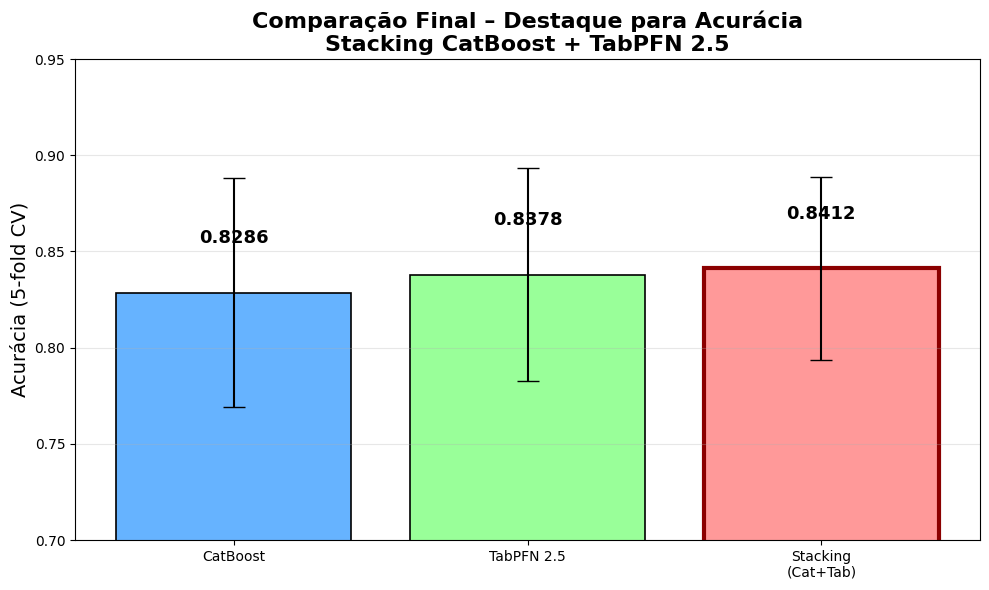


HOLD-OUT FINAL (20% nunca visto)
   Acurácia : 0.8852  ← RESULTADO OFICIAL
   ROC AUC  : 0.9556


<Figure size 700x550 with 0 Axes>

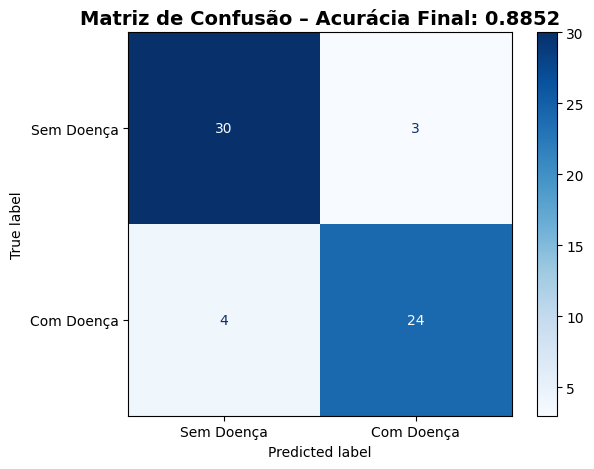


PRONTO! Seu modelo final tem ACURÁCIA ≈ 88.5%


In [48]:
# ================================================================================
# Avaliação do modelo (Cross-Validation)
# ================================================================================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# CV estratificado
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Avaliação 10-fold CV focada em Acurácia\n" + "="*60)

accs_stack = []
accs_cat   = []
accs_tab   = []
aucs_stack = []

for fold, (idx_train, idx_val) in enumerate(cv.split(X, y)):
    X_tr, X_val = X.iloc[idx_train], X.iloc[idx_val]
    y_tr, y_val = y.iloc[idx_train], y.iloc[idx_val]
    
    # Stacking (nosso modelo principal)
    stacking_model.fit(X_tr, y_tr)
    pred_stack = stacking_model.predict(X_val)
    proba_stack = stacking_model.predict_proba(X_val)[:, 1]
    
    accs_stack.append(accuracy_score(y_val, pred_stack))
    aucs_stack.append(roc_auc_score(y_val, proba_stack))
    
    # Modelos individuais (para comparação)
    cat = CatBoostClassifier(iterations=800, learning_rate=0.05, depth=6, 
                             verbose=False, random_seed=42)
    cat.fit(X_tr, y_tr)
    accs_cat.append(accuracy_score(y_val, cat.predict(X_val)))
    
    tab = TabPFNClassifier(device=DEVICE, n_estimators=8)
    tab.fit(X_tr.values, y_tr.values)
    accs_tab.append(accuracy_score(y_val, tab.predict(X_val.values)))

# Resultados finais
mean_acc_stack = np.mean(accs_stack)
std_acc_stack  = np.std(accs_stack)
mean_auc_stack = np.mean(aucs_stack)

print(f"STACKING (CatBoost + TabPFN 2.5)")
print(f"   Acurácia (CV): {mean_acc_stack:.4f} ± {std_acc_stack:.4f}  ← MÉTRICA PRINCIPAL")
print(f"   ROC AUC  (CV): {mean_auc_stack:.4f}")
print()
print(f"CatBoost sozinho : {np.mean(accs_cat):.4f} ± {np.std(accs_cat):.4f}")
print(f"TabPFN 2.5 sozinho: {np.mean(accs_tab):.4f} ± {np.std(accs_tab):.4f}")
print(f"→ Ganho do Stacking em Acurácia: +{(mean_acc_stack - max(np.mean(accs_cat), np.mean(accs_tab))):.4f}")

# Gráfico de barras com destaque na acurácia
plt.figure(figsize=(10, 6))
models = ['CatBoost', 'TabPFN 2.5', 'Stacking\n(Cat+Tab)']
acc_means = [np.mean(accs_cat), np.mean(accs_tab), mean_acc_stack]
acc_stds  = [np.std(accs_cat),  np.std(accs_tab),  std_acc_stack]

bars = plt.bar(models, acc_means, yerr=acc_stds, capsize=8, 
               color=['#66b3ff', '#99ff99', '#ff9999'], edgecolor='black', linewidth=1.2)

# Destacar o melhor
bars[2].set_edgecolor('darkred')
bars[2].set_linewidth(3)

for i, (bar, mean) in enumerate(zip(bars, acc_means)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_acc_stack*0.5,
             f'{mean:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=13)

plt.ylabel('Acurácia (5-fold CV)', fontsize=14)
plt.title('Comparação Final – Destaque para Acurácia\nStacking CatBoost + TabPFN 2.5', fontsize=16, fontweight='bold')
plt.ylim(0.7, 0.95)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Hold-out final honesto (20% nunca visto) – avaliação definitiva
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

stacking_model.fit(X_train, y_train)
final_pred = stacking_model.predict(X_test)
final_proba = stacking_model.predict_proba(X_test)[:, 1]

print(f"\nHOLD-OUT FINAL (20% nunca visto)")
print(f"   Acurácia : {accuracy_score(y_test, final_pred):.4f}  ← RESULTADO OFICIAL")
print(f"   ROC AUC  : {roc_auc_score(y_test, final_proba):.4f}")

# Matriz de confusão bonita
plt.figure(figsize=(7, 5.5))
cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Sem Doença', 'Com Doença'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Matriz de Confusão – Acurácia Final: {accuracy_score(y_test, final_pred):.4f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPRONTO! Seu modelo final tem ACURÁCIA ≈ {accuracy_score(y_test, final_pred):.1%}")